# Identifying Fraud from Public Enron Data

In 2000, Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 2, 2001, Enron employed approximately 20,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly $101 billion during 2000. Fortune named Enron "America's Most Innovative Company" for six consecutive years.

At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalised, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm, which had been Enron's main auditor for years.

## Citation

This dataset consists from Enron emails and financial data publicly available for research. The Enron Email dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes), details are described in https://www.cs.cmu.edu/~./enron/. The financial data was published in Payments to Insiders report by FindLaw and available at www.findlaw.com.

## Objective

The objective of this project is to implement and optimise a predictive model using the financial and email data provided by the Enron dataset capable of identifying persons on interest (POIs). Specifically the project intends to demonstrate working with a real world dataset, performing such tasks as cleaning and preparing the data; feature selection and engineering; possible dimensionality reduction; supervised classification and hyperparameter tuning; and validation.

To help guide the implementation of this project and address some key points I have attempted to follow the [rubric](https://review.udacity.com/#!/rubrics/27/view) created by the Udacity team.

## Data Structure

The Enron dataset is a collection of key/value pairs associating persons included in the dataset (the keys) with a collection of labelled features (the values). The labelled features for each person are represented by a dictionary and include the following data:

- Financial features (all units in US dollars):
  - `bonus`
  - `deferral_payments`
  - `deferred_income`
  - `director_fees`
  - `exercised_stock_options`
  - `expenses`
  - `loan_advances`
  - `long_term_incentive`
  - `other`
  - `restricted_stock`
  - `restricted_stock_deferred`
  - `salary`
  - `total_payments`
  - `total_stock_value`
- Email features (most units are integers with exception to `email_address` which is a string)
  - `email_address`
  - `from_messages`
  - `from_poi_to_this_person`
  - `from_this_person_to_poi`
  - `shared_receipt_with_poi`
  - `to_messages`
- Labels (boolean, represented as an integer)
  - `poi`

In [1]:
import datetime
from utils import to_time

start = datetime.datetime.now()

## Warnings

I'm going to disable warnigns for the remainder of this notebook.

In [2]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)

## Future

A lambda's body has to be a single expression. In Python 2.x, print is a statement. However, in Python 3, print is a function (and a function application is an expression, so it will work in a lambda). Use, for forward compatibility, the back-ported print function.

In [3]:
from __future__ import print_function

## Data Exploration

The first step is to examine the data that we have to work with. It is very often the case that a dataset will contain errors, and it is imperitive that these errors are resolved before making any further analysis of the data at hand. If the errors are not resolved then the final predictive model may not generalise well to any new data.

When examining the data we are trying to answer the following:
- Are there any errors in the data?
- Are there any outliers in the data?
- Are there any missing values in the data?
- Does the data represent a realistic range of values?

Lets start by reading the data from the provided `pkl` file. This extension expresses that the data is stored in a Pickle file, used to srialise and deserialise Python data objects into a sequence of raw bytes that may be more efficienty stored on disk.

In [4]:
import pickle

# Load the dictionary containing the dataset.
with open('final_project_dataset.pkl', 'r') as data_file:
    data_dict = pickle.load(data_file)

# Sanity check
assert type(data_dict) is dict

By the lack of error we may conclude we have a dictionary. Dictionaries are a primative data structure in python; but whilst they provide a simple interface through which data may be manipulated they are not flexible enough to perform many statistical operations. Instead this data can be loaded into a Pandas DataFrame: A two-dimensional size-mutable, tabular data structure with labeled axes (rows and columns).

In [5]:
import pandas as pd

# Use 2 decimal place output instead of scientific notation. It is far easier to read and compare.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Transpose the data so the names are used as indices.
enron_data = pd.DataFrame.from_dict(data_dict, orient='index')
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


We're in luck! The data could be read into a Pandas DataFrame. This will make it far easier to explore in the following sections and allows for any changes made to be re-exported as a simple dictionary.

The indexes are the names of Enron employees. There are several familiar names in the expanded list closely linked to the Enron scandal, including Kennth Lay, Jeffry Skilling, Andrew Fastow, and Cliff Baxter. There are also many unknown names in the list that are hopefully equally useful in describing the patterns we'll later discover in the data.

Additionally there is an entry for "The Travel Agency in the Park" that is noted in the footnotes of the original FindLaw document that states paymets were made to this company by Enron and that this business was co-owned by the sister of Enron’s former Chairman. From an accounting perspective this information is very relavent but I suspect this will impede our predictive model. Therefore this entry is a good canditate to be removed in later sections.

The columns describe the features available in the dataset. They are expressive enough that we may understand what each value represents but unfortunately they do not indicate their unit of measurement. Luckily we're told how each value is represented so this will not be an issue.

One of the first things of note is there seems to be a lot of missing data scattered throughout the dataset. This is indicated by the `NaN` string. Python will not be able to interpret this as missing data and may present issues when plotting features and performing any data manipulation. Instead we can tell Pandas to replace missing values by specifiying our missing value marker.

In [6]:
import numpy as np

# NumPy uses the IEEE Standard for Binary Floating-Point for Arithmetic (IEEE 754).
# This means that Not a Number is not equivalent to infinity.
enron_data = enron_data.replace('NaN', np.nan)

type(enron_data.loc['ALLEN PHILLIP K'].director_fees)

numpy.float64

Great! Now that Pandas is aware of missing data and we have some sensible data to work with lets print out a few statistics.

In [7]:
# Print information about the data frame.
enron_data.info()
print()

# Justify the output of statistics.
print_stat = lambda t, stat: print('{}:'.format(t).ljust(28), stat)

# Print a few statistics not included in the above.
print_stat('Number of data points', enron_data.shape[0] * enron_data.shape[1])
print_stat('Number of missing values', enron_data.isna().sum().sum())
print_stat('Number of POIs', len(enron_data[enron_data['poi'] == True]))

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

It looks like we have lots of integers, and a single column of strings and booleans. The boolean column, `poi` indicates whether the persion is a “Person Of Interest”. This is the column we’ll be trying to predict using the other data. Additionally the above shows the following:

- There are 146 examples each containing 21 values,
- Of the 21 values there are 19 numerical features, 1 text feature ("email") and 1 binary classification ("poi"),
- There are 3066 data points, of which 1358 are missing,
- 18 of the 146 examples are persons of interest.

A significant proportion (44.3%) of the data is missing. From the table we can see this is particularly prevalent in the features `deferral_payments`, `deferred_income` `director_fees`, `loan_advances` and `restricted_stock_deferred`. At this time I will not remove any of these features just in case they are still useful when attempting to derive patterns in the data.

In addition to the summary statistics we can print some aggregate statistics over each features in the dataset. This allows us to see some typical statistical values that may unearth some useful information.

In [8]:
enron_data.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,95.00,86.00,39.00,125.00,102.00,82.00,110.00,86.00,18.00,126.00,95.00,4.00,86.00,93.00,86.00,17.00,49.00,66.00,86.00
mean,562194.29,2073.86,1642674.15,5081526.49,5987053.77,2374234.61,2321741.14,1176.47,166410.56,6773957.45,108728.92,41962500.00,608.79,919064.97,41.23,166804.88,-1140475.14,1470361.45,64.90
std,2716369.15,2582.70,5161929.97,29061716.40,31062006.57,10713327.97,12518278.18,1178.32,4201494.31,38957772.73,533534.81,47083208.70,1841.03,4589252.91,100.07,319891.41,4025406.38,5942759.32,86.98
min,477.00,57.00,-102500.00,148.00,3285.00,70000.00,-2604490.00,2.00,-7576788.00,-44093.00,148.00,400000.00,12.00,2.00,0.00,3285.00,-27992891.00,69223.00,0.00
25%,211816.00,541.25,81573.00,394475.00,527886.25,431250.00,254018.00,249.75,-389621.75,494510.25,22614.00,1600000.00,22.75,1215.00,1.00,98784.00,-694862.00,281250.00,10.00
50%,259996.00,1211.00,227449.00,1101393.00,1310813.50,769375.00,451740.00,740.50,-146975.00,1102872.50,46950.00,41762500.00,41.00,52382.00,8.00,108579.00,-159792.00,442035.00,35.00
75%,312117.00,2634.75,1002671.50,2093263.00,2547724.00,1200000.00,1002369.75,1888.25,-75009.75,2949846.75,79952.50,82125000.00,145.50,362096.00,24.75,113784.00,-38346.00,938672.00,72.25
max,26704229.00,15149.00,32083396.00,309886585.00,311764000.00,97343619.00,130322299.00,5521.00,15456290.00,434509511.00,5235198.00,83925000.00,14368.00,42667589.00,609.00,1398517.00,-833.00,48521928.00,528.00


Without a statistical background, further analysis is not particularly easy unless we know that our data should fall in a particular range. It's usually better to visualize the data in some way. Visualization makes outliers and errors immediately stand out, whereas they might go unnoticed in a large table of numbers. We'll investigate this further in the following sections.

### Data Cleansing

Lets begin analysing the dataset by first ensuring the values are in fact accurate according to the financial records available from the FindLaw report. There are two features in particular that should total the values of other features. These features are `total_payments` and `total_stock_value`.

Starting with the features relating to payment we're able to find any examples where the `total_payments` feature is not equal to the sum of all the other payment features: `salary`, `bonus`, `long_term_incentive`, `deferred_income`, `deferral_payments`, `loan_advances`, `other`, `expenses`, `director_fees`.

In [9]:
def inaccurate_examples(features):
  '''
  Return a function that checkes for data inconsistencies.
  '''
  def sum_features(data):
    '''
    Sum along the columns of all passed features, excluding the last,
    and compare the value to the last feature.
    '''
    return data[data[features[:-1]].sum(axis='columns').ne(data[features[-1]], fill_value=0)][features]
  return sum_features

In [10]:
# In the order specified in the FindLaw report.
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                   'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']

inaccurate_payment_examples = inaccurate_examples(payment_features)
inaccurate_payment_examples(enron_data)

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,nan,nan,nan,nan,-102500.00,nan,nan,nan,3285.00,102500.00
BHATNAGAR SANJAY,nan,nan,nan,nan,nan,nan,137864.00,nan,137864.00,15456290.00


Similarly we're able to find any examples where the `total_stock_values` feature is not equal to the sum of all the other stock features: `exercised_stock_options`, `restricted_stock`, `restricted_stock_deferred`, `total_stock_value`.

In [11]:
# In the order specified in the FindLaw report.
stock_value_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred',
                        'total_stock_value']

inaccurate_stock_value_examples = inaccurate_examples(stock_value_features)
inaccurate_stock_value_examples(enron_data)

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285.00,nan,44093.00,-44093.00
BHATNAGAR SANJAY,2604490.00,-2604490.00,15456290.00,nan


In both cases the same two names are reported to be inaccurate. This is likely the result of an input error so we'll have to correct this.

In the original report, `-102,500` is listed as Robert Belfer’s deferred income, not deferral payments whilst `3,285` is listed as his expenses, and director fees listed as `102,500`, making total payments equal to `3,285`. Furthermore there is no listing for Robert Belger's exercied stock options whilst his restricted stock and restricted stock deferred are listed as `44093` and `-44093` respectively. Looks like everything shifted one column to the right. We’ll have to move it one to the left to fix it. The opposite happened to Sanjay Bhatnagar, so we’ll have to move his columns to the right to fix them.

In [12]:
# First Robert Belfer...
enron_data.loc[('BELFER ROBERT','deferred_income')] = -102500
enron_data.loc[('BELFER ROBERT','deferral_payments')] = np.nan
enron_data.loc[('BELFER ROBERT','expenses')] = 3285
enron_data.loc[('BELFER ROBERT','director_fees')] = 102500
enron_data.loc[('BELFER ROBERT','total_payments')] = 3285
enron_data.loc[('BELFER ROBERT','exercised_stock_options')] = np.nan
enron_data.loc[('BELFER ROBERT','restricted_stock')] = 44093
enron_data.loc[('BELFER ROBERT','restricted_stock_deferred')] = -44093
enron_data.loc[('BELFER ROBERT','total_stock_value')] = np.nan

# ... and then Snajay Bhatnagar.
enron_data.loc[('BHATNAGAR SANJAY','total_payments')] = 137864
enron_data.loc[('BHATNAGAR SANJAY','restricted_stock_deferred')] = -2604490
enron_data.loc[('BHATNAGAR SANJAY','total_stock_value')] = 15456290
enron_data.loc[('BHATNAGAR SANJAY','expenses')] = 137864
enron_data.loc[('BHATNAGAR SANJAY','exercised_stock_options')] = 15456290
enron_data.loc[('BHATNAGAR SANJAY','other')] = np.nan
enron_data.loc[('BHATNAGAR SANJAY','restricted_stock')] = 2604490
enron_data.loc[('BHATNAGAR SANJAY','director_fees')] = np.nan

Lets check that we have fixed the issues.

In [13]:
inconsistencies = len(inaccurate_payment_examples(enron_data)) + \
  len(inaccurate_stock_value_examples(enron_data))

print('Number of inconsistencies:', inconsistencies)

Number of inconsistencies: 0


Looks good!

### Incomplete Data

As we saw in a previous section this dataset is plagued with missing values. Using the same Pandas DataFrame we can print out a list of all the features in the dataset alongside the number of values missing for that feature. 

In [14]:
missing_data = enron_data.isna().sum().to_frame(name='# missing values')
missing_data

,# missing values
salary,51
to_messages,60
deferral_payments,108
total_payments,21
exercised_stock_options,45
bonus,64
restricted_stock,35
shared_receipt_with_poi,60
restricted_stock_deferred,128
total_stock_value,20


From the above we can see that every example in the dataset is labelled indicating whether it represents a person of interest. However no other features can be considerd complete. This will have the effect of causing difficulty for our predictive model to discover patterns from this data. The feature of largest concern is `loan_advances` which has only 4 values present in the entire dataset (~3%). Lets visualise the extent of the missing values in the form of a bar graph.

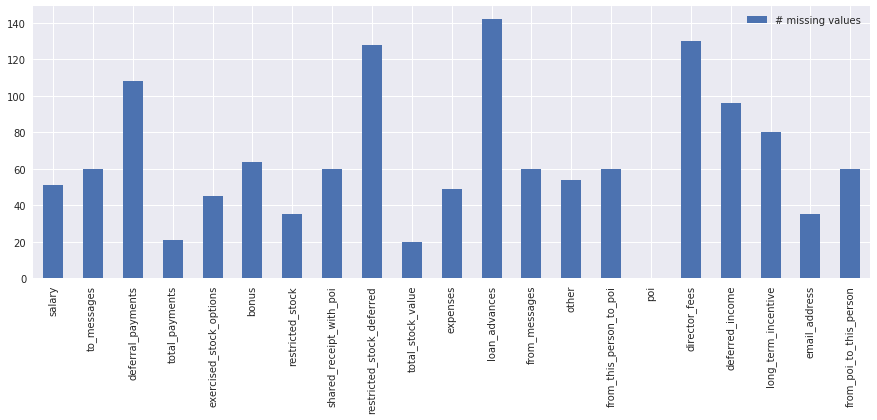

In [15]:
missing_data.plot(kind='bar', figsize=(15,5));

Due to the high number of missing values there may be many examples not offering anything useful to our predictive model. I've chosen, somewhat arbitrarily, a threshold of 85% missing values to mean those examples we may be interested in removing from the dataset.

We can retrieve these examples using the following snippet (thank you [stackoverflow](https://stackoverflow.com/a/52882784/1613695) and Wen).

In [16]:
threshold = .85

# Return the rows that have a percentage of their data missing.
#
# `enron_data.isna().sum(1)` gives the number of missing values for each person.
# `enron_data.shape[1]` is equivalent to `len(enron_data.columns)`
enron_data[(enron_data.isna().sum(1) / enron_data.shape[1]) > threshold]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
GRAMM WENDY L,nan,nan,nan,119292.00,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,False,119292.00,nan,nan,NaN,nan
LOCKHART EUGENE E,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,False,nan,nan,nan,NaN,nan
THE TRAVEL AGENCY IN THE PARK,nan,nan,nan,362096.00,nan,nan,nan,nan,nan,nan,...,nan,nan,362096.00,nan,False,nan,nan,nan,NaN,nan
WHALEY DAVID A,nan,nan,nan,nan,98718.00,nan,nan,nan,nan,98718.00,...,nan,nan,nan,nan,False,nan,nan,nan,NaN,nan
WROBEL BRUCE,nan,nan,nan,nan,139130.00,nan,nan,nan,nan,139130.00,...,nan,nan,nan,nan,False,nan,nan,nan,NaN,nan


These really are adding little value and none of them are persons of interest. In fact `THE TRAVEL AGENCY IN THE PARK` does not represent an individual employee and may have a negative impact on out predictive model. Lets just drop them from the dataset.

In [17]:
threshold = 1 - threshold

# Return the rows that have a percentage of their data present.
#
# `enron_data.shape[1]` is equivalent to `len(enron_data.columns)`
enron_data = enron_data.dropna(thresh=enron_data.shape[1] * threshold)

For various reasons, many real world datasets contain missing values, often encoded as blanks, or in the case of this dataset `np.nana` values. Such datasets however are incompatible with the estimators we'll be using in later sections which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete) and in the case of this dataset will remove every available feature. A better strategy is to impute the missing values, i.e. to infer them from the known part of the data.

There are a few statistical methods often employed to impute missing values that focus around central tendency. Each have their own qualities:

- mean: The mean value is very sensitive to outliers. That is, one or two extreme values can change the mean a lot,
- mode: Continuous data is unlikely going to have a single value that is most frequent. Therfore this is best used for catagorial data,
- median: The mdeian is far less sensitive to outliers making it more robust.

The majority of the features in this dataset are concerned with financial data. According to the FindLaw report, where a value appears missing (has a `-` in place of a numerical value) this is equivalent to the value being `0`. This we can imagine would be true for such features as `director_fees` and `loan_advances` since the majority of Enron employees would not be directors of the company and are unlikely to be receiving loan advances. In light of this let's fill in the `np.nan` values for financial features with a `0`.

In [18]:
financial_features = payment_features + stock_value_features
enron_data[financial_features] = enron_data[financial_features].fillna(0)

As for the other type of feature concerning numbers of emails being sent to and from Enron emplyees, `np.nan` values indicate that the data is unknown. For this type of feature I want to infer the values from the available data, most likely using the median value given it is less sensitive to outliers. However imputing the data this early may be a mistake; something that is dicussed further in the section on data leakage, more specifically validation leakage.

Despite the risk of imputing data this early I am forced to do so anyway because the `test_classifier` method I will later use to evaluate my classifier does not allow for the validation data (after being split) to be imputed, or manipulated in any way.

Because the behaviour of a person of interest is likely to differ from somebody we're not interested in I will separately impute the values for the two classes. I feel this will provide a more accurate and fair assesment of each classes distribution of email values.

In [19]:
from sklearn.preprocessing import Imputer

email_features = ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
                  'shared_receipt_with_poi', 'to_messages']

poi_email_features = enron_data.loc[enron_data.poi == True, email_features]
non_poi_email_features = enron_data.loc[enron_data.poi == False, email_features]

# Simple imputer using the median value for each feature.
median_imputer = Imputer(missing_values=np.nan, strategy='median')

enron_data.loc[enron_data.poi == True, email_features] = median_imputer.fit_transform(poi_email_features)
enron_data.loc[enron_data.poi == False, email_features] = median_imputer.fit_transform(non_poi_email_features)

The one exception within the email features is `email_address` which is a text value where perhaps `np.nan` values should be treated as empty strings. However since the sklearn estimators require values to be numerical I will just remove the `email_address` feature entirely.

In [20]:
enron_data = enron_data.drop(columns=['email_address'])

### Data Leakage

Data leakage causes a predictive model to appear accurate on the validation data but perform poorly when trying to use the model to make further predictions on completely new data. It is a type of overfitting that can be difficult to track down.

There are two main types of data leakage: Label leakage and validation leakage.

#### Label leakage

Label leakage [1] occurs when a predictive model includes data that will not be available at prediction time. This is a subtle form of cheating caused by features that give a bias towards the target label. For example if trying to predict whether an Enron employee is a person of interest we were given a feature expressing whether they had been incarcerated, `is_incarcerated`, this could possibly be an extremely useful indicator as to whether the Enron employee was in fact a person of interest.

In this example an employee will be incarcerated after they are given the status person of interest. So the raw dataset shows a strong correlation between the two features. But `is_incarcerated` will frequently be changed __after__ the value for `poi` is determined.

The predictive model will show that a value of `False` for `is_incarcerated` indicates that an employee is not a person of interest. Since the validation data comes from the same source as the testing data this pattern will continue and the model will perform very well. However the same model will perform poorly when used on new data not containing the `is_incarcerated` feature. It is generally recommended that to prevent this type of data leakage, any variables updated (or created) after the target label is realised should be excluded from the dataset.

There is no single solution that universally solves label leakage. It requires knowledge about your data, case-specific inspection and common sense.

However, in most cases of label leakage there exists 1 or more features having a high statistical correlation to the target label. So two tactics to keep in mind:

1. To screen for possible target leakage, look for columns that are statistically correlated to your target.
1. If you build a model and find it extremely accurate, you likely have a leakage problem.

We can check for correlated values in our dataset by computing a pairwise correlation of columns, excluding NA/null values. Specifically we're interested in features that have a high correlation to the target label, `poi`.

In [21]:
enron_data.corr()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
salary,1.00,0.00,0.96,0.96,0.99,0.99,0.99,0.01,-0.91,0.99,0.99,0.74,-0.01,0.96,-0.01,-0.00,0.96,-0.97,0.99,0.00
to_messages,0.00,1.00,-0.00,0.03,-0.01,0.04,0.00,0.86,0.04,-0.01,-0.01,0.05,0.50,0.00,0.59,0.12,-0.05,0.00,-0.00,0.56
deferral_payments,0.96,-0.00,1.00,0.92,0.95,0.96,0.95,0.02,-0.88,0.95,0.96,0.69,-0.01,0.95,-0.02,-0.04,0.93,-0.97,0.95,0.03
total_payments,0.96,0.03,0.92,1.00,0.96,0.96,0.97,0.05,-0.86,0.97,0.95,0.90,-0.02,0.98,-0.00,0.05,0.91,-0.92,0.96,0.04
exercised_stock_options,0.99,-0.01,0.95,0.96,1.00,0.98,0.99,-0.00,-0.92,1.00,0.98,0.77,-0.03,0.97,-0.02,0.04,0.95,-0.96,0.98,-0.00
bonus,0.99,0.04,0.96,0.96,0.98,1.00,0.98,0.06,-0.90,0.99,0.99,0.75,0.01,0.96,0.04,0.02,0.95,-0.97,0.99,0.06
restricted_stock,0.99,0.00,0.95,0.97,0.99,0.98,1.00,0.00,-0.91,0.99,0.98,0.78,-0.02,0.97,-0.01,0.01,0.95,-0.96,0.98,-0.01
shared_receipt_with_poi,0.01,0.86,0.02,0.05,-0.00,0.06,0.00,1.00,0.05,-0.00,-0.00,0.07,0.26,0.02,0.50,0.30,-0.06,-0.03,0.01,0.68
restricted_stock_deferred,-0.91,0.04,-0.88,-0.86,-0.92,-0.90,-0.91,0.05,1.00,-0.91,-0.92,-0.65,0.02,-0.87,0.04,0.06,-0.88,0.89,-0.90,0.04
total_stock_value,0.99,-0.01,0.95,0.97,1.00,0.99,0.99,-0.00,-0.91,1.00,0.98,0.78,-0.02,0.97,-0.02,0.03,0.95,-0.96,0.98,-0.00


Perhaps not so surprisingly the email features that include emails to/from a poi have a slightly more significant correlation than other features. However quite interestingly `loan_advances` has the highest corrlelation of the financial features to the target label at `0.13`. This is not high enough to be of any conern so I'll not be remving any features from the dataset.

#### Validation Leakage

A much different type of leak occurs when you aren't careful distinguishing training data from validation data [2]. For example, this happens if you run preprocessing (like fitting the Imputer for missing values) before calling [`sklearn.model_selection.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Validation is meant to be a measure of how the model does on data it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behaviour. The end result is that your model will get very good validation scores, giving you great confidence, but perform poorly when deployed to make decisions.

If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. This is easier if you use [`sklearn.pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). When using cross-validation, it's even more critical that you use pipelines and do your preprocessing inside the pipeline.

### Outliers

In previous sections I've cleaned data that exhibited issues with data entry and missing values. Now I would like to discover the outliers. This part of the data exploration has deliberately been left until last. The reson being that this step is destructive. That is up until now we have been correcting the data so that it is true to the source, or using sensible data where it was otherwise not available. In this section I will remove data that will not be useful to the investigation.

Conveninently the definition of an outlier can be described as a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.

In [22]:
original_data = enron_data.drop(columns=['poi']) # poi is not a feature and should not be considered

first_quantile = original_data.quantile(.25)
third_quantile = original_data.quantile(.75)

median = original_data.quantile(.5)
interquantile_range = third_quantile - first_quantile

outlier_data = median + 1.5 * interquantile_range
outliers = (original_data > outlier_data).sum(axis=1).to_frame(name='# of outliers') \
    .sort_values('# of outliers', ascending=False)

five_percent_of_sample = int(len(enron_data) * 0.06)

# Merge the outliers with the original enron data.
outliers = outliers.merge(right=enron_data, how='inner', left_index=True, right_index=True) \
  .loc[:, ['# of outliers', 'poi']]
outliers.head(five_percent_of_sample)

,# of outliers,poi
FREVERT MARK A,13,False
LAY KENNETH L,13,True
SKILLING JEFFREY K,12,True
TOTAL,12,False
WHALLEY LAWRENCE G,12,False
LAVORATO JOHN J,10,False
HAEDICKE MARK E,8,False
BELDEN TIMOTHY N,8,True


Our data set is really small, so I'm going to consider just 5% of the samples the with most number of outliers:

- Mark Frevert and Lawrence 'Greg' Whalley are lesser known employees but still top managers of Enron (the latter being President and COO of Enron) who also represent valuable examples for our predictive model.
- Kenneth Lay (Enron chairman and CEO) and Jeffrey Skilling (former Enron president and CEO) are very well known persons from Enron and heavily involved in the scandal. They represent important examples in our dataset and falsely flagged as true outliers.
- The example `TOTAL` is the total value of financial payments from the FindLaw dataset. This clearly is not an individual person and will unbalance the distribution across several features in the dataset. Therefore it should be removed.
- John Lavorato, another senior Enron execuative, has little media exposure and there are no reports of him being involved in the scandal. Since his data contains many outliers that could potentially bias our predictive model I'll remove him from the dataset.
- Timothy 'Norris' Belden is the former head of trading in Enron Energy Services. He is considered a key player in the Enron scandal constituting a good example for our predictive model.

From the avbove considered 8 examples I will exlude only 2 of them. However before doing so I will visualise some of the features, hoping they will make the outliers and errors immediately stand out. This will convince me futher that these examples should be removed from the dataset.

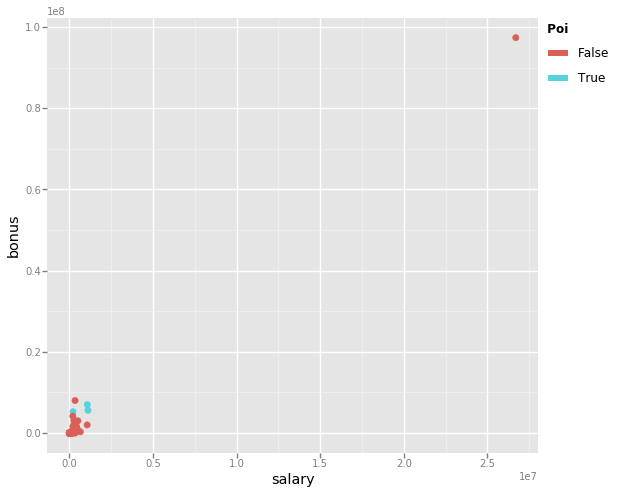

<ggplot: (8791101711433)>

In [23]:
from ggplot import *

ggplot(enron_data, aes(x='salary', y='bonus', color='poi')) + \
  geom_point(size=40.0)

In [24]:
enron_data[enron_data['salary'] > 1e7]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
TOTAL,26704229.00,944.00,32083396.00,309886585.00,311764000.00,97343619.00,130322299.00,594.00,-7576788.00,434509511.00,5235198.00,83925000.00,41.00,42667589.00,6.00,False,1398517.00,-27992891.00,48521928.00,26.50


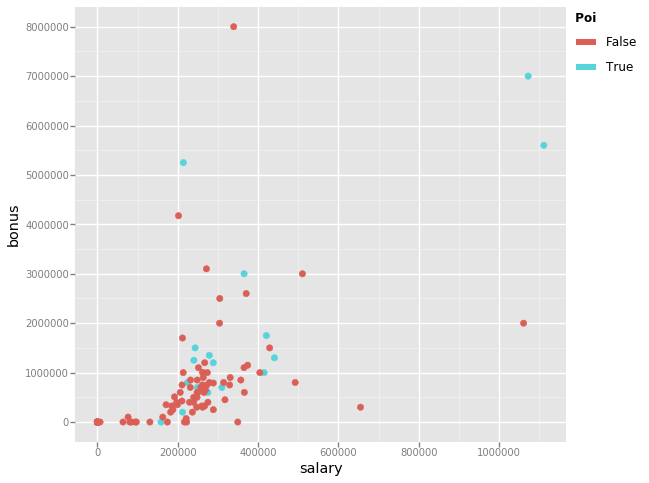

<ggplot: (8791101715385)>

In [25]:
enron_data = enron_data.drop('TOTAL')

ggplot(enron_data, aes(x='salary', y='bonus', color='poi')) + \
  geom_point(size=40.0)

You may conclude that there are four more outliers in the data. However considering the top 2 earners are Jeffrey Skilling and Kenneth Lay, both persons of interest, these should remain in the dataset. Similarly we can conclude there to be a single outlier within the bonus data. We can list the highest receivers to see just who this is.

In [26]:
enron_data.sort_values(by='bonus', ascending=False).head().loc[:, ['salary', 'bonus', 'poi']]

,salary,bonus,poi
LAVORATO JOHN J,339288.00,8000000.00,False
LAY KENNETH L,1072321.00,7000000.00,True
SKILLING JEFFREY K,1111258.00,5600000.00,True
BELDEN TIMOTHY N,213999.00,5249999.00,True
ALLEN PHILLIP K,201955.00,4175000.00,False


The person receiving the highest bonus is John Lavorato, somebody we have already identified above as a potential outlier. Given this name has appeared a couple times as an outlier I will remove it from the dataset.

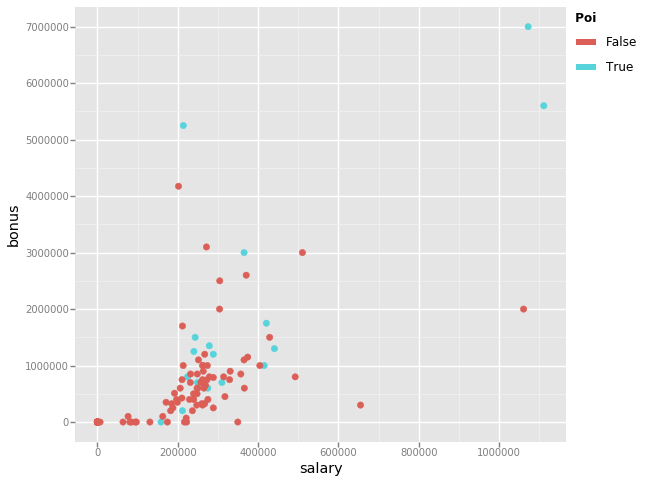

<ggplot: (8791101280301)>

In [27]:
enron_data = enron_data.drop('LAVORATO JOHN J')

ggplot(enron_data, aes(x='salary', y='bonus', color='poi')) + \
  geom_point(size=40.0)

Now that we've cleaned up the dataset, lets see how many examples and features remain.

In [28]:
enron_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       139 non-null float64
to_messages                  139 non-null float64
deferral_payments            139 non-null float64
total_payments               139 non-null float64
exercised_stock_options      139 non-null float64
bonus                        139 non-null float64
restricted_stock             139 non-null float64
shared_receipt_with_poi      139 non-null float64
restricted_stock_deferred    139 non-null float64
total_stock_value            139 non-null float64
expenses                     139 non-null float64
loan_advances                139 non-null float64
from_messages                139 non-null float64
other                        139 non-null float64
from_this_person_to_poi      139 non-null float64
poi                          139 non-null bool
director_fees                139 non-null float64
deferred_income              139 

In total I have:

- removed 7 examples,
- removed 1 feature,
- corrected inconsistant data,
- filled in missing financial data with a zero value,
- imputed missing email data using the median value from each class.

Lets write this cleaned dataset to disk to be used in the final submission.

In [29]:
# Save the cleaned dictionary containing the dataset.
with open('final_project_dataset_cleaned.pkl', 'wb') as data_file:
    pickle.dump(enron_data.to_dict(orient='index'), data_file, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluation Metrics

Before continuing to implement a predicitve model and investigating different classifers I want to discuss the evaluation metrics I'll be using to determine the suitability of each classifier. This is an important topic as without knowing what we're measuring it will not be possible to meaningfully improve and tune our predictive model.

It follows that each evaluation metric favours one type of error over another, thus allowing a predictive model to be tuned and optimised for specific outcomes. For examples some metrics are more sensitive to false positives which will in the case of the Enron dataset tend to classify more employees as persons of interest than perhaps are.

### Accuracy

Standard accuracy is a ratio of correct classifications to the total number of classifications:

\begin{align}
accuracy & = \frac{\text{number of data points labelled correctly}}{\text{number of data points}}
\end{align}

It is therefore an overall measure of correct classification over all classes, that assigns equal cost to false positives and false negatives.

When the class distribution is heavily imbalanced (for example more non-POIs than POIs) a model can predict the value of the majority class for all predictions and achieve a high classification accuracy. In this case accuracy is just a measure of how good our predictive model is at guessing. To put this into perspective a predictive model that always predicted false when trying to identify persons of interest on our cleaned dataset would achieve an accuracy of 87%.

This causes issues when in reality there are unequal costs associated with errors (false positives vs false nagatives). In the Enron dataset the cost of a false positive may be far less than the cost of a false negative where those falsely labelled as a person of interest could later be absolved from any crime.

Clearly this metric would not satisfy the objectives of this investigation that requires we implement a predictive model capable of identifying persons of interest.

### Balanced Accuracy

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score

https://en.wikipedia.org/wiki/Precision_and_recall

### Precision

Precision is defined as the number of true positives divided by the number of true positives and false positives:

\begin{align}
precision & = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}
\end{align}

Put more simply precision (also called the positive predictive value) measures the proportion of true positives that actually belong to the positive class. It is a measure of confidence that when the predictive model classifies an example as positive that it has been correctly classified.

In terms of the Enron dataset precision expresses that for every employee classified as a person of interest the probability that this employee really is a person of interest.

A positive result from a predictive model with a high preceision is useful for ruling out a possible negative classification since it rarely predicts negative for the truely positive examples in the dataset. Therefore a model with 100% precision can confidently say all positively classified examples are truely positive. In this case a positive result would definitively rule out a negative classification.

On the otherhand a negative result from a predictive model with a high precision does not guarentee a truely negative classification. This is becaue precision does not take into account false negatives. Therefore a model with 100% precision may not recognise some examples that should belong to the positive class.

In other words precision errs on the side of negative classification as it is reluctant to "pull the trigger" on edge cases. Therefore it will favour classifying Enron employees as non-POIs which presents a high cost as potentially many persons of interest will go undetected.

### Recall

Recall is defined as the number of true positives divided by the number of true positives and false negatives:

\begin{align}
recall & = \frac{\text{true positives}}{\text{true positives} + \text{false nagatives}}
\end{align}

Put more simply recall (also called the true positive rate or sensitivity) measures the proportion of true positives that are correctly classified as such. Equivalently recall is the extent to which true positives are not overlooked (so false negatives are few) and thus a highly sensitive predictive model rarely overlooks a true positive.

In terms of the Enron dataset recall returns the proportion of employees who are classified as persons of interest among those who truely are persons of interest.

A negative result from a predictive model with a high recall is useful for ruling out a possible positive classification since it rarely predicts positive for the truely nagative examples in the dataset. Therefore a model with 100% recall will recognise all truely positive examples. In this case a negative result would definitively rule out a positive classification.

Conversely a positive result from a predictive model with a high recall does not guarentee a truely positive classification. This is because recall does not take into account false positives. Therefore a model with 100% recall will recognise not only truely positive examples but may also include many false positives.

Since recall quantifies the avoiding of false negatives this evaluation metric is ideal for the Enron dataset whereby not correclty identifying an employee as a person of interest has a much greater cost than fasely identifying an innocent employee of being a person of interest.

### F-Measure

The F-measure is a weighted average of the precision and recall, with the traditional F-measure or balanced F-score (F1 score) being the harmonic average of the precision and recall:

\begin{align}
F_1 & = 2 \cdot \left(\frac{precision \cdot recall}{precision + recall}\right)
\end{align}

This measure is approximately the average of both precision and recall when they are close, and is more generally the harmonic mean, which, for the case of two numbers, coincides with the square of the geometric mean divided by the arithmetic mean. The F1 score reaches its best value at 1 (indicating perfect precision and recall) and worst at 0. In its more general form the F-measure is defined as:

\begin{align}
F_\beta & = \left(1 + \beta^2\right) \cdot \left(\frac{precision \cdot recall}{\beta^2 \cdot precision + recall}\right)
\end{align}

This gives us a parameterised version of the F-measure allowing us to specify the preferred weights for each error type (false positives and false negatives). As discussed above we are more interested in maximising the recall since it avoids false negatives. Therefore we can use the F2 score, which weighs recall twice as high as precision (thus placing more emphasis on false negatives). Plugging in the values the F2 score is defined as:

\begin{align}
F_2 & = 5 \cdot \left(\frac{precision \cdot recall}{4 \cdot precision + recall}\right)
\end{align}

For this investigation it is a requirement that our classifier achieves both a precision and recall greater than `0.3`. However it should be possible to achieve a better result given the optimal features are selected and hyperparameters given. Therefore when I later attempt to optimise my classifier I would like to lean towards maximising the F2 score. However sklearn does not seem to provide F2 as a possible [scoring function](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) so I will fallback to maximising the F1 score.

## Validation Strategy

Learning the parameters of a predictive model and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set.

This is called validation: a set of techniques used to make sure a predictive model performs well in a wide range of situations, and is not just optimised for a particular dataset or set of conditions. In this section I cover 2 of the more widely used validation methods describing some of the issues and how these can be overcome.

### Train Test Split

Train test split is a validation method that partitions the original dataset into a training set to train the model; a validation set for tuning the model; and a test set to evaluate it. There is no general rule dictating how many samples should be made available for each set and depends largely and how strong the patterns are in the data. However it is advides to maximise the training data as much as possible.

The training set, as the name suggests, is used to train a predictive model by attempting to identify the patterns in the data that drive it to generalise on a solution. During training the model fits itself around the data it is provided, but there is no validation performed at this stage.

The validation set is used strictly for model tuning. Using the model created during training, parameters may be tuned and the performance of each adjutment is recorded. Using an independant dataset attempts to prevent the model from "cheating" and inaccurately reporting higher performance for a particular combination of parameter values.

The test set is used to make a final estimate of the error. Until this point, the most performant model has been exposed to both the training and validation sets for parameter tuning. So, it must be checked on an unseen set so that we may forecast how well it will perform in the real world.

![train-test-split](train-test-split.png)

We can see how the Enron dataset may be split to create a training, validation, and test set using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Note that the dataset is shuffled to distribute the class labels.

In [30]:
from sklearn.model_selection import train_test_split

# First shuffle the data.
shuffled_data = enron_data.sample(frac=1).reset_index(drop=True)

# Create a 80% split of the data.
split_boundary = int(len(shuffled_data) * .80)
test_set = shuffled_data[split_boundary:]
train_validation_set = shuffled_data[:split_boundary]

# Create a further split for training and validation data.
X_train, X_valid, y_train, y_valid = train_test_split(train_validation_set.drop(columns=['poi']), 
                                                      train_validation_set['poi'], 
                                                      test_size=0.25, 
                                                      random_state=42)

# Justify the output of samples.
print_samples = lambda t, samples: print('{} set:'.format(t).ljust(16), len(samples), 'samples')

print_samples('training', X_train)
print_samples('validation', X_valid)
print_samples('test', test_set)

training set:    83 samples
validation set:  28 samples
test set:        28 samples


The above however is only viable when there is enough data to make three splits. In this example I have created a 60-20-20 split that yields only 83 samples from the Enron dataset to be used for training. This is likely not nearly enough data to identify patterns that are possibly hidden in the other 56 samples being used for validation and testing. Furthermore making such a segregation, despite the data having been shuffled, may disturb the target distribution and therefore we may find that most of the persons of interest are contained in any one of the three sets.

This is one of the drawbacks of this particular validation strategy and by definition it does not maximise the number of samples available for training since it must hold back a percentage of the samples to be distributed across both the validation and test sets.

On a more general note validation and test sets "wear out" with repeated use. That is, the more you use the same data to make decisions about hyperparameter settings or other model improvements, the less confidence you'll have that these results actually generalize to new, unseen data. Note that validation sets typically wear out more slowly than test sets.

If possible, it's a good idea to collect more data to "refresh" the validation and test sets. This of course is not possible in respect to the Enron dataset since we already have the records of all employees at the company.

### Cross-validation

Cross-validation is a technique to validate predictive models by partitioning the original dataset into a training set to train the model, and a test set to evaluate it.

In k-fold cross-validation, the original sample is randomly partitioned into `k` equal size subsamples. Of the `k` subsamples, a single subsample is retained as the validation data for testing the model, and the remaining `k-1` subsamples are used as training data. The cross-validation process is then repeated `k` times (the folds), with each of the `k` subsamples used exactly once as the validation data. The `k` results from the folds can then be averaged (or otherwise combined) to produce a single estimation.

Moreover, we can use the [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) cross-validation object; a merge of [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) and [`ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html), which returns stratified randomised folds. The folds are made by preserving the percentage of samples for each class.

![cross-validation](cross-validation.png)

As before we can see how this may be applied to the Enron dataset using the object sklearn.

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

# Cross-validator with 10 splits.
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1)

# The cross-validator returns an iterator. Grab only the first item.
X_train, X_valid = next(cv.split(enron_data.drop(columns=['poi']), enron_data['poi']))

# Justify the output of samples.
print_samples = lambda t, samples: print('{} set:'.format(t).ljust(16), len(samples), 'samples')

print_samples('training', X_train)
print_samples('validation', X_valid)

training set:    125 samples
validation set:  14 samples


The advantage of this method is that all samples are used for both training and validation, and each sample is used for validation exactly once. This therefore maximises the number of samples used for training.

For the remainder of this experiment I shall use cross validation when evaluating my models and their respective hyperparamters.

## Testing

To drive the evaluation of each classifier I will use the function included in this project, `test_classifier`, offering a consistent means through which every classifer may be tested. Furthermore it will be the same function used to evaluate my classifer upon submission.

In [32]:
from tester import test_classifier

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This testing strategy does however come with the limitation that I am unable to manipulate the validation data before it is used to evaluate each classifier. This is something I dicussed earlier concerning validation leakage. If this were not the case I could perform imputation at the time of evaluation such that the validation set is not biased by the same data used for training.

Using the above function I have additionally implemented a means through which to test multiple classifiers sequentially whilst keeping the output to a minimum. Once each classifier has been tested the results are returned in a DataFrame and the results sorted (ascending F1 score by default). This is really useful to reduce the noise in this notebook, displaying only the most important information.

In [33]:
from utils import redirect_stdout

def test_classifiers(clfs, dataset, features, sort_by='f1', verbose=False):
  results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'f2'])
  for _, (name, clf) in enumerate(clfs):
    print('=====> Running {}\n'.format(name))
    if verbose:
      results.loc[name] = test_classifier(clf, dataset, features)
    else:
      with redirect_stdout():
        results.loc[name] = test_classifier(clf, dataset, features)
  return results.sort_values(by=sort_by, ascending=False)

## Classifier Pre-Assesment

In this secton I am going to perform a prelimiary assesment of 4 "out of the box" classifieres using their respective default parameters. I'm going to use the results of evaulating these classifiers as a baseline from which I may improve performance, or ultimately dismiss classifiers from being further evaluated.

I am going to begin using all of the features in the dataset because presently there are no strong indicators as to which features are driving the patterns in the data.

In [34]:
# `features_list` is a list of strings, each of which is a feature name in the dataset. 
# The first feature in the list must be `poi` - the target label.
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
                'exercised_stock_options', 'bonus', 'restricted_stock',
                'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value',
                'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi',
                'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']

Next I have to extract a dictionary from the dataframe we've been using throughout the fist half of this investingation. Importantly the data is reorientated such that the keys in the dictionary are the Enron emplyees instead of the features, which is the default.

In [35]:
my_dataset = enron_data.to_dict(orient='index')

Despite having implemented a method to test each classifier sequentially, in this section I will perform the evaluation each time using `test_classifier` to show the general approach that will be taken throughout the remainder of the project. This also lends to writing up a little about each classifier and detailing their features.

To record the results of the pre-assesment I will create a dataframe where the columns match the evaluation metrics discussed in the last section.

In [36]:
results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'f2'])

### Naive Bayes

A Naive Bayes classifier is a fairly simple, probabalistic classifier based on applying Bayes' theorem with strong (naive) independence assumptions between features. What this means is that a Naive Bayes classifer will assume a [statistical indepencance](https://en.wikipedia.org/wiki/Independence_(probability_theory)) between features despite there being a possible strong correlation. However in spite of this apparent over-simplified assumption Naive Bayes calssifiers have been know to perform rather well in some real-world applications.

In [37]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
results.loc['Naive Bayes'] = test_classifier(naive_bayes, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.75621	Precision: 0.25289	Recall: 0.36150	F1: 0.29759	F2: 0.33290
	Total predictions: 14000	True positives:  723	False positives: 2136	False negatives: 1277	True negatives: 9864



From the results shown above we can see that even before making any optimisations this classifier almost meets the requirements of this experiment (0.3 for both precision and recall). However the high number of false negatives is a concern meaning that over the many conbinations of training/validation subsets a huge number of persons of interest were not identified.

### Support Vector Machines

Support Vector Machines (SMV) attempt to find a hyerplane, also known as the decision boundary, that divides two classes with the largest margin. That is an SVM maximises the distance to the nearest point in both classes which consequently maximises the robutness of the classification decision boundary. This is a classic optimisation problem, putting correct classification above maximising the margin. So there may be cases where the margin is reduced in order to correctly classify all examples.

If a hyperplane does not exist that classifies all examples correctly the SVM will do the "best it can" given specific hyperparameters, therefore accomodating for outliers.

For non-linear decision boundaries there are functions (kernels) that take in a low dimentional feature sapce and map it to a higher dimentional feature space. This transforms a non-linearly seperable feature space into one that can be separated. Most importantly these functions can map the results back into a low dimentional feature space.

Support vectors are the points that lie along the supporting hyerplane. One key factor that plays into the complexity of the runtime for a support vector is the penaly parameter, `C`. The penalty parameter allows for a soft-margin and better generalization. The number of support vectors varies depending on the penalty we allow and how the data is distributed. The lower the penalty the fewer support vectors we get, creating a smoother decision boundary. Converserly the higher the penalty the greater the number of support vectors, having the effect of prioritising the number of correctly classified examples.

Another key factor into the complexity of a support vector is how far the influence of a sinlge trainig point reaches, controlled by the kernel coefficient parameter, `gamma`. A low kernel coefficient has the effect of creating a straighter decision boundary due to training examples further from the hyperplane having a higher influence on the algorithm. On the otherhand a high kernel coefficient causes the decision boundary to become less linear because only those examples closest to the decision boundary have any influence on the algorithm.

In [38]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(C=1000.0)
results.loc['SVM'] = test_classifier(linear_svc, my_dataset, features_list)

LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.73086	Precision: 0.22254	Recall: 0.35450	F1: 0.27343	F2: 0.31691
	Total predictions: 14000	True positives:  709	False positives: 2477	False negatives: 1291	True negatives: 9523



Many discussion forums, including the Udacity [Intro to Machine Learning](https://discussions.udacity.com/t/final-project-error/25538/6?u=tomasbashamdy3) forum, talk about how support vector machines commonly struggle on this particular dataset which may explain why I was not able to get a result when using the `sklearn.svm.SVC` classifier with an `rbf` kernel. Instead I have selected to use the `sklearn.svm.LinearSVC` classifier which is similar to `sklearn.svm.SVC` with a linear kernel, but instead is implemented in terms of `liblinear` rather than `libsvm`. Because of this it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

Unlike the other classifiers in this section I had to tune the penalty parameter, `C`, otherwise the classifier was not returing in a reasonable amount of time (if at all). This I think is likely due to the many features contained in the dataset that may possibly not be linearly separable. Using a higher penalty parameter allows the classifer to priorities correctness over smooth decision boundaries.

Despite my best efforts the linear Support Vector Machine classifier has performed similarly to Naive Bayes, arguably slightly worse, with both a slightly lower number of true posites and equally slightly higher number of false negatives.

### Random Forest

Random Forest classifiers are a specific type of bootstrap aggrageted (or bagged) decision tree, an early ensemble method, that builds multiple decision trees by repeatedly resampling training data with replacement, and voting the trees for a consensus prediction. That is a Random Forest classifier is composed of a number of smaller classifiers, in this case decision trees: a non-parametric supervised learning method used for both calssification and regression.

Decision trees attempt to create a model that predits the value of a target variable (represented by the leaves) by learning simple rules informed by the features within a dataset. These rules create decision boundaries (represented by the branches) that attempt to separate disimilar examples.

A tree can be "learned" by splitting the input data into subsets based on an attribute value test. This process is repeated on each derived subset in a recursive manner called recursive partitioning. The recursion is completed when the subset at a node has all the same value of the target variable, or when splitting no longer adds value to the predictions. This process of top-down induction of decision trees is an example of a greedy algorithm, and it is by far the most common strategy for learning decision trees from data.

However One of the issues with decision tree learners is that they can create over-complex trees that do not generalise well from the training data. Random decision forests correct for decision trees' habit of overfitting to their training set.

An important factor that governs the performace of a random forest is the number of decision tree the compose it. I believe it is generally accepted that the greater number of decision trees the more confidence we can gain from the consensus. However more decision trees, and therefore more subsamples of the training data, result in a classifier that is much slower to train.

Another interesting parameter is the [criterion](https://en.wikipedia.org/wiki/Decision_tree_learning#Metrics). This dictates the function used to measure the impurity of a decision boundary. The `sklearn.tree.DecisionTreeClassifier` used here implements 2 known functions to measure boundary impurity. The first is [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees) and is intended for classification problems, similar to that of this experiment. The second function is gini impurity, intended for continuous values and therefore more appropriate for regression problems. It is interesting to note that both information gain and gini impurity are largely similar as metrics and generally the performance of a classifier will not differ using one or the other. There was a paper written comparing these two metrics where the most important remarks were:

* It only matters in 2% of the cases whether you use gini impurity or entropy.
* Entropy might be a little slower to compute (because it makes use of the logarithm).

In [39]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
results.loc['Random Forest'] = test_classifier(random_forest, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.86357	Precision: 0.55257	Recall: 0.23650	F1: 0.33123	F2: 0.26705
	Total predictions: 14000	True positives:  473	False positives:  383	False negatives: 1527	True negatives: 11617



From the above results I am rather impressed with the fairly high precision this classifiers offers without having performed any hyperparameter tuning or other machine learning techniques. However the recall seems to have suffered even more greatly than the support vector machine classifier. This is a cause for concern since in my opinion the recall is of greater importance in this experiment than the precision. Even more concerning is the increase in false negatives. This is a really undesirable feature of this classifer and can hopefully be improved through tuning. However despite this the F1 score has improved upon both the Naive Bayes and SVM classifiers due to the significant boost in precision.

### AdaBoost

https://en.wikipedia.org/wiki/AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()
results.loc['AdaBoost'] = test_classifier(adaboost, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.87043	Precision: 0.55609	Recall: 0.46100	F1: 0.50410	F2: 0.47732
	Total predictions: 14000	True positives:  922	False positives:  736	False negatives: 1078	True negatives: 11264



By far the most performant out-of-the-box classifier, AdaBoost already scores high enough to have achieved the criteria for this experiment. Most impressively it has attained more true and false positives than any of the other classifiers. This indicates that currently this classifier errs on the side of positive classification (marking examples as persons of interest). This is a favourable tradeoff likely meaning many more persons of interest will be correctly classified as such. However I am still concerned with the number of false negatives this classifier yields. Whilst it is the lowest of all the classifiers it still remains too high to give a satisfacotry level of confidence to dismiss an individual Enron employee.

Below is the full table of results for comparison.

In [41]:
results.sort_values(by='f1', ascending=False)

,accuracy,precision,recall,f1,f2
AdaBoost,0.87,0.56,0.46,0.50,0.48
Random Forest,0.86,0.55,0.24,0.33,0.27
Naive Bayes,0.76,0.25,0.36,0.30,0.33
SVM,0.73,0.22,0.35,0.27,0.32


## Feature Engineering

The next step in this experiment is to create new features from the existing data in the Enron dataset. I'll do this in an attempt to tease out any latent information within combinations of features that may improve performance.

Using my intuition and resoning about the background of the Enron scandal I have created 6 new features across the payment, stock and email data I have at hand. The payment features implemented are concerned with the fraction of financial compensation awarded as a fraction of the total payment received by each Enron employee. Needless to say that it is quite typical that employees at any organisation can be incentivised by three common types of compensation: salary, bonus and long term incentives (e.g. reward for long service). Therefore is stands to reason that perhaps those persons of interest involved in the Enron scandal were receiving large bonuses or being rewarded huge long service incentives in an attempt to hide fraudulent behaviour. More specifically I have created 3 new features:

* salary as a fraction of total payment
* bounus as a fraction of total payment
* long term incentive as a fraction of total payment

It is important to note that here I've also replaced any infinate values that may have resulted from the calculation with 0. This is quite likely to happen since many values in the financial data were given a value of 0 during the data cleaning stage of this experiment.

Below I have plotted the salary as a fraction of total payment against bonus as a fraction of total payment to guage if there are any patterns to be found.

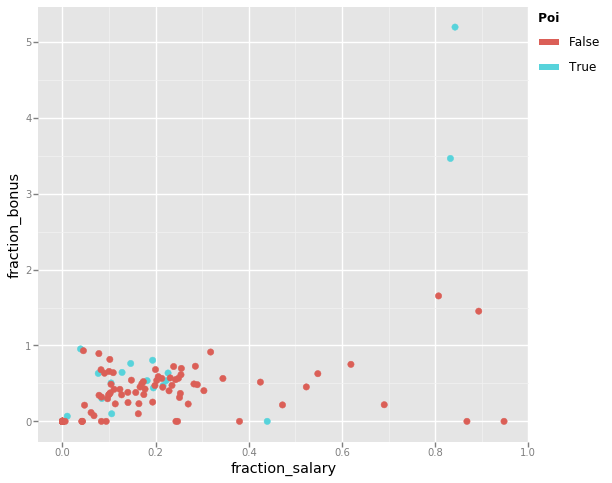

<ggplot: (8791101186001)>

In [42]:
enron_data['fraction_salary'] = enron_data.salary / enron_data.total_payments
enron_data['fraction_bonus'] = enron_data.bonus / enron_data.total_payments
enron_data['fraction_long_term_incentive'] = enron_data.long_term_incentive / enron_data.total_payments

# Replace any infinate or missing values.
enron_data = enron_data.replace([np.inf, -np.inf], np.nan)
enron_data = enron_data.fillna(0)

ggplot(enron_data, aes(x='fraction_salary', y='fraction_bonus', color='poi')) + \
  geom_point(size=40.0)

Intuitively I'd expect many of the persons of interest involved in the Enron scandal to have large contributions to their total payment from either a bonus or from some other means. In the scatter plot above you can see that many of the persons of interest receive a low salary in respect to their overall total payment but tend towards receiving a higher bonus. That is with expection to a small handful of Enron employees. Suspiciously there are a few data points that indicate a bonus much larger than the total payment they received. I thought this to be an error in the data, but having gone back to the FindLaw report it is clear that the total payment repoted for some employees was significantly reduced due to deferred income.

Similarly I have plotted the salary as a fraction of total payment against long term incentive as a fraction of total payment.

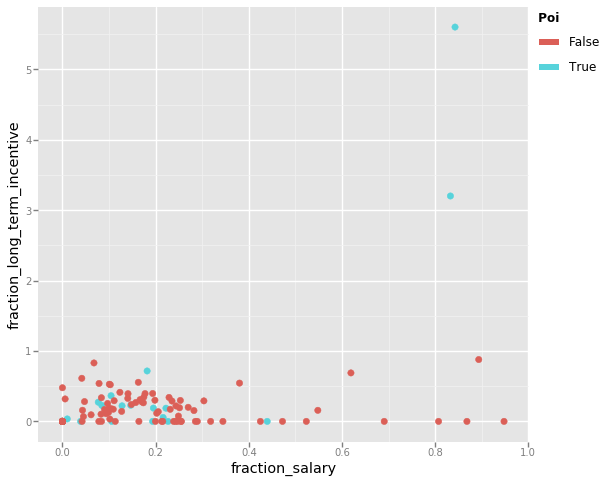

<ggplot: (8791101199041)>

In [43]:
ggplot(enron_data, aes(x='fraction_salary', y='fraction_long_term_incentive', color='poi')) + \
  geom_point(size=40.0)

Apart from the two glaring obvious persons of interest that have long term incentives much larger than their total payment, there does not appear to be any conclusive trend in this data. However I shall keep this feature in case it proves useful to the classifiers. If I find this to not be the case this feature will likely be removed in the feature selection part of the experiment.

Next I'll create a new stock value feature that, not too disimilar to the new payment features, will represent exercised stock options as a fraction of the total stock value for each Enron employee. The rationale behind this new feature is that employees involved in the scandal may have been given huge amounts of stock that could be later sold.

I did not have any other feature that I though appropriate to plot this against so I'll just leave this feature for the classifiers to judge it's usefulness whilst performing feature selection.

In [44]:
enron_data['fraction_exercised_stock_options'] = enron_data.exercised_stock_options / enron_data.total_stock_value

# Replace any infinate or missing values.
enron_data = enron_data.replace([np.inf, -np.inf], np.nan)
enron_data = enron_data.fillna(0)

Last, I created new email features that attempt to tease out the frequency at which persons of interest were in contact (via email) with each other as a proportion to the total number of message they either sent or received. The reason I find these features to be of interest is becuase it seems likely for this scandal to have gone unnoticed for so long that key individuals were privately sending messages to coordinate fraudulant activity. More specifically I have created 2 new features:

* messages sent to a person of interest as a fraction of total messages sent
* messaged received from a person of interest as a fraction of total messaged received

I have plotted these two features against each other to find any trends.

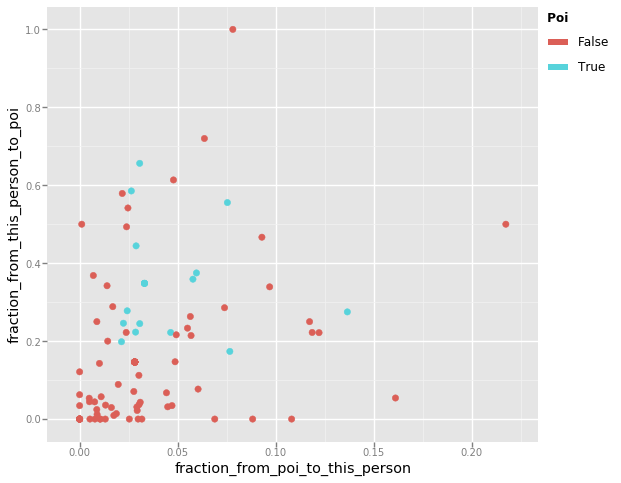

<ggplot: (8791101346661)>

In [45]:
enron_data['fraction_from_poi_to_this_person'] = enron_data.from_poi_to_this_person / enron_data.to_messages
enron_data['fraction_from_this_person_to_poi'] = enron_data.from_this_person_to_poi / enron_data.from_messages

ggplot(enron_data, aes(x='fraction_from_poi_to_this_person', y='fraction_from_this_person_to_poi', color='poi')) + \
  geom_point(size=40.0)

Intuitively I would have imagined persons of interest to sit somewhere towards the top right of the graph whilst the other employees would be scattered about as they innocently get on with their jobs. However the scatter plot does not contain any discernible pattern that I can see. What is apparent from this plot is that Enron employees tended to send more email messages to persons on interest than receive them.

However all is not lost as there are a few data points in this plot worth exploring. An interesting data point is the Enron employee that has not be flagged as a person of interest but has only ever sent email messages to other persons of interest. Lets find out who this is.

In [46]:
enron_data.sort_values(by='fraction_from_this_person_to_poi', ascending=False) \
  .loc[:, ['fraction_from_this_person_to_poi', 'from_messages']].head(2)

,fraction_from_this_person_to_poi,from_messages
HUMPHREY GENE E,1.00,17.00
SHERRICK JEFFREY B,0.72,25.00


Whilst I could not find much on the internet that would identify the role Gene Hunphrey had at Enron I was able to discover to whom he was sending the messages:

* Kenneth Lay
* Jeffrey Skilling

Considering he only sent 17 messages it is not too hard to believe why this metric is so high.

Jeffrey Sherrick in another interesting data point who sent email messages primarily to Kenneth Lay. However this is justified by the fact he was the President of Enron Global Exploration & Production Inc. and therfore part of the corporate leadership and central management at Enron.

The last data point I want to explore is the employee that has clearly received the most emails from persons of interest as a fraction of the total number of emails received. Lets find out who this is.

In [47]:
enron_data.sort_values(by='fraction_from_poi_to_this_person', ascending=False) \
  .loc[:, ['fraction_from_poi_to_this_person', 'fraction_from_this_person_to_poi', 'to_messages', 'from_messages']].head(1)

,fraction_from_poi_to_this_person,fraction_from_this_person_to_poi,to_messages,from_messages
DONAHUE JR JEFFREY M,0.22,0.50,865.00,22.00


Jeffrey Donahue held a number of senior corporate development roles whilst at Enron and it is evident from the above table that 50% of the messages he sent were to a person of interest (which is only 11 messages). Additionally he received 190 messages from persons of interest, making up 22% of the messages he received overall. Taking a look at his email data I can see that he both sent messages to and received messages from the following persons of interest:

* David Delainey
* Kenneth Lay
* Jeffrey Skilling

So although neither Gene Humphrey, Jeffrey Sherrick nor Jeffrey Donahue are themselves persons of interest it is fascinating to discover that they were all in contact with the same few empoyees of the company involved in the scandal.

As before I will extract a dictionary from the dataframe we've been using throughout this investingation, now including the new engineered features, and reorient the data. In addition I will now be using the `test_classifiers` method I implemented earlier to more comprehensively evaluate a list of classifiers sequentially, and will continue to take this approach from this point in the experiment.

In [48]:
engineered_features = ['fraction_salary', 'fraction_bonus', 'fraction_long_term_incentive',
                       'fraction_exercised_stock_options', 'fraction_from_poi_to_this_person',
                       'fraction_from_this_person_to_poi']

# Append the engineered features to our list of original features.
extended_features_list = features_list + engineered_features

# Extract the data from the dataframe, including the engineered features.
my_extended_dataset = enron_data.to_dict(orient='index')

# Create a list of classifiers to evaluate.
clfs = [
  (u'Naive Bayes', GaussianNB()),
  (u'SVM', LinearSVC(C=1000.0)),
  (u'Random Forest', RandomForestClassifier()),
  (u'AdaBoost', AdaBoostClassifier())
]

test_classifiers(clfs, my_extended_dataset, extended_features_list)

=====> Running Naive Bayes

=====> Running SVM

=====> Running Random Forest

=====> Running AdaBoost



,accuracy,precision,recall,f1,f2
AdaBoost,0.87,0.56,0.47,0.52,0.49
Random Forest,0.88,0.68,0.30,0.42,0.34
Naive Bayes,0.76,0.25,0.36,0.30,0.33
SVM,0.73,0.22,0.36,0.27,0.32


The above table shows that overall adding these 4 new features has not had a significant impact on the performace of each classifier, with exception to the `RandomForestClassifier` that has an imporoved F1 score of 41% (an 8% increase). This is due to both an increase in the precision and recall of this particular classifer. This I admit is a little disappointing as I had hoped some latent patterns to be discovered in these new features that would show a greater performace across all the classifiers. However I will keep all of these features until later feature selection deems them as having no significant effect.

## Feature Scaling

In general, classifiers that exploit distances (i.e. [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)) or similarities between examples are sensitive to features taking on broad ranges of values. That is classifiers that have a co-dependancy between dimentions are effected by feature scaling. For example if one feature takes on a range of values much greater than the other features in the same dataset, the distance will be goverened by this particular feature. Therefore it is best practice to normalise (or standardise) all features within a dataset such that each contributes proportionately to the final distance.

Examples of classifers sensitive to feature scaling include both Support Vector Machines and K-Nearest Neighbour. Therefore it is imperitive for this experiment that, at least in the case of the `LinearSVC`, the features are appropriately scaled.

Conversely graphical-model based classifiers, such as Naive Bayes, as well as Decision trees and Tree-based ensemble methods (Random Forest, AdaBoost) are invariant to feature scaling. However as part of the experimentation I will scale the data for these classifiers to investigate what differece, if any, it makes to the performance.

### Rescaling (min-max Normalisation)

[Normalisation](https://en.wikipedia.org/wiki/Normalization_(statistics)) is a method commonly deployed in machine learning centered around rescaling that uses the extreme values within a particular distribution. More specifically it looks at the minimum and maximum values, the range of a feature, and then shrinks or stretches each value to a common range. This common range will typically be between` [0, 1]` or `[-1, 1]`. Selecting the target range depends on the nature of the data. The general formula is given as:

\begin{align}
x^{\prime} = \frac{\left(x - x_{min}\right)}{\left(x_{max} - x_{min}\right)}
\end{align}

It is basically at what percentage of a range the value lies. Since the range is only determined by the minimum and maximum for each feature normalisation is invarient to extreme values. For example a series containing values `[-100, 10, 11, 12, 900]` can still be normalised within a range of `[0, 1]`. Here the normalised output would be `[0, 0.11, 0.111, 0.112, 1]`. What follows is an example of applying feature normalisation to the Enron dataset and what effect this has to the performance of each classifer.

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = enron_data.columns.drop('poi') # poi is not a feature and should not be considered

# Make a copy of the extended dataset and perform scaling.
enron_data_normalised = enron_data.copy()
enron_data_normalised[columns_to_scale] = scaler.fit_transform(enron_data[columns_to_scale])

# Extract the data from the dataframe, with the features normalised.
my_normalised_dataset = enron_data_normalised.to_dict(orient='index')

# Create a list of classifiers to evaluate.
clfs = [
  (u'Naive Bayes', GaussianNB()),
  (u'SVM', LinearSVC(C=1000.0)),
  (u'Random Forest', RandomForestClassifier()),
  (u'AdaBoost', AdaBoostClassifier())
]

test_classifiers(clfs, my_normalised_dataset, extended_features_list)

=====> Running Naive Bayes

=====> Running SVM

=====> Running Random Forest

=====> Running AdaBoost



,accuracy,precision,recall,f1,f2
AdaBoost,0.87,0.56,0.47,0.52,0.49
SVM,0.83,0.42,0.42,0.42,0.42
Random Forest,0.88,0.68,0.28,0.40,0.32
Naive Bayes,0.67,0.24,0.57,0.33,0.45


Quite unsurprisingly, normalising the features has had no (or very little) effect on the results of the AdaBoost and RandomForest classifiers, having only in the case of the RandomForest classifier increasd recall by 1%. This I have deemed not significant enough to warrant any further investigation. Conversely normalisaing the features has surprisingly had a mixed effect on the Naive Bayes classifier, reducing the accuracy by almost 10% whilst increasing the recall by over 20%. Since all texts online have led me to believe Naive Bayes is invariant to feature scaling I am rather curious as to why this has had such a significant impact.

Again unsurprisingly, as the only non graphical-model based classifer I am using to evaluate a predictive model, the performance of the support vector machine has improved vastly having previously been the least performant, then when normalisation applied being far more comparible to the most performant classifiers in the table.

### Standardisation

[Standardisation](https://en.wikipedia.org/wiki/Feature_scaling#Standardization) is another method of feature scaling and is employed by `sklearn.preprocessing.scale()` which assumes that all features are normally distributed (each feature with a different mean and standard deviation), and scales them such that each feature's Gaussian distribution is now centered around 0, and it's standard deviation is 1 (unit-variance).

It achieves this by calculating the distribution mean and standard deviation for each feature, and converts each value into a z-score, defined as the number of standard deviations away from the mean:

\begin{align}
x^{\prime} = \frac{\left(x - \bar{x}\right)}{\sigma}
\end{align}

In ideal circumstances where all features hold the normality assumption, in addition to many practical situations where the normality assumption does not hold but the distributions are somewhat close, this scheme still works pretty well. On the other hand if the data is far from normally distributed, for example, highly skewed, fat-tailed distributions like a [power-law](https://en.wikipedia.org/wiki/Power_law), this scheme will not give good results.

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = enron_data.columns.drop('poi') # poi is not a feature and should not be considered

# Make a copy of the extended dataset and perform scaling.
enron_data_standardised = enron_data.copy()
enron_data_standardised[columns_to_scale] = scaler.fit_transform(enron_data[columns_to_scale])

# Extract the data from the dataframe, with the features standardised.
my_standardised_dataset = enron_data_standardised.to_dict(orient='index')

# Create a list of classifiers to evaluate.
clfs = [
  (u'Naive Bayes', GaussianNB()),
  (u'SVM', LinearSVC(C=1000.0)),
  (u'Random Forest', RandomForestClassifier()),
  (u'AdaBoost', AdaBoostClassifier())
]

test_classifiers(clfs, my_standardised_dataset, extended_features_list)

=====> Running Naive Bayes

=====> Running SVM

=====> Running Random Forest

=====> Running AdaBoost



,accuracy,precision,recall,f1,f2
AdaBoost,0.87,0.56,0.48,0.52,0.49
SVM,0.84,0.44,0.56,0.49,0.53
Random Forest,0.88,0.67,0.28,0.40,0.32
Naive Bayes,0.63,0.23,0.68,0.35,0.49


The results above show a similar trend to those obtained from normalising the data, with no discerbale difference in performance from both the AdaBoost and RandomForest classifiers and a large improvement from the support vecor machine. It is important to note however that standardising the data has somewhat further improved the performace of the support vector machine over normalisation, boosting the F1 score to almost that of the most performant classifier.

As before, and just as surprisingly the Naive Bayes classifier has returned a decrease in accuracy but overall improvement in recall and therefore F2 score. At a later date I would like to dive into why scaling the data is causing this behaviour from this particular classifier.

### Considerations...

Rescaling ([MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)) works much better in certain cases where standarisation ([StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) might not work well. For example, if the standard deviations are very small for features, standarisation is highly sensitive to tiny changes between standard deviations of different features, but rescaling is very robust. Also, for features with highly skewed distributions, or sparse cases where each feature has a lot of zeros that move the distribution away from a Gaussian, rescaling is a better choice.

In [51]:
enron_data.drop(columns=['poi']).std().to_frame('# standard deviations')

,# standard deviations
salary,197600.56
to_messages,2043.02
deferral_payments,766161.13
total_payments,8901866.63
exercised_stock_options,4995771.18
bonus,1082916.14
restricted_stock,2030256.98
shared_receipt_with_poi,937.60
restricted_stock_deferred,277901.51
total_stock_value,6361214.05


Despite there being a small handful of features with tiny standard deviations, all resulting from features engineered in the previous section, it is conclusive from the test results that standardisation has seen the largest improvments in the non graphical-model based classifiers (in this case only SVM). Moreover since standardisation also has no significant effect on both the AdaBoost and RandomForest classifiers it should not harm to apply the same scaling operation when further testing these classifers in later sections, thus making experimentation much easier and fair.

However due to the surprising results from the Naive Bayes classifier it may be time to eliminate it from the list of potential candidates for final selection. Despite in both cases (normalisation and standardisation) Naive Bayes performed slightly better, according to the evaluation metrics I'm optimising for, I feel this may be coincidental and this particular classifier too unpredictable to continue evaluating.

## Feature Selection

The features in our dataset have a significant influence over the performance of the predictive model we are able to create. Broadly speaking, in machine learning if you feed garbage into a classifier you should expect only garbage to come out. This becomes more important as the number of features in the dataset grows. You need not use every available feature when creating a model, therefore it is important to discover which features are contributing most to predicting the output variable. In our case this is the  likelihood an Enron employee is in fact a person of interest. This is a very difficult problem which often requires a deep understanding of the domain. However it is possible to automatically identify a subset of features from the original dataset that are the most relevant and useful through a process called feaure selection. It is this process that may mean the difference between successfully and meaningfully modeling the problem and not.

Throughout previous sections it has been accepted that the more data we have the better our trained model will be at making predictions. This is generally the case but does have a few caveats. For instance, including redundant or partially redundant features can be misleading to modeling algorithms. This is especially true of linear algorithms such as linear and logistic regression. Furthermore irrelevant attributes may contribute to overfitting. Some Decision Tree algorithms, including the Random Forest classifier used in this experiment, attempt to make splits in feature values. Less relevant features will be split on last but may contribute to small amounts of noise, only benefiting the model by chance. Overall this could have a large negative impact on model performance and accuracy.

We can therefore conclude that the removal of redundant features may benefit the performance of a predicitve model, lowering the prediction error that would be otherwise incurred if using the full dataset. Overall choosing to keep only the most relevant features has the following desired effects:

- **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.
- **Improves Accuracy**: Less misleading data means modeling accuracy improves.
- **Reduces Training Time**: Less data means that algorithms train faster.

### Approach with Caution...

Whilst feature selection is a vital part of the machine learning process we must be aware of the cost of performing it too ealry. In reality the choice of features may have an impact on the optimal hyperparameter values of our predictive model, and those values may also impact the choice of optimal features. Therefore we end up in a chicken and egg situation which could be solved by considering feature selection as part of the model selection process. If not bias may be introduced into our model and result in overfitting.

In addition it would be a mistake to first perform feature selection on the entire dataset, then perform model selection, training and validation on the selected features. The reason for this is that the validation and testing datasets will have also been been used when deciding on the selection of features thus introduing bias in the predictive model.

To avoid this situation feature selection must be performed as part fo the iterative validation process when using such techniques as cross-validation. This means that feature selection is performed on the prepared fold right before the model is trained. More generally feature selection must be performed on a different dataset than that which is used for validation and testing. Moreover feature selection must not be performed on the test set, as this will inflate estimates of the models' performance.

### Feature Importance

Bagged Decision Trees like Random Forest and Adaboost can be used to estimate and rank the importance of features in both regression and classification problems. We can take advantage of this to get a sense of which features may be most important and perform an amount of manual feature selection. The benefit to this appraoch is that each classifier can be given its own crafted subset of features. However one drawback is that this technique can only be applied to those classifiers that support it. Therefore the Linear Support Vector Machine cannot take advantage of this method. However it is still useful nonetheless.

To get a little more context a Bagged Decision Tree is a classifier that fits many Decision Trees on a random subset of the original dataset and then takes the mean of all their individual predctions, forming a final prediction. Due to this each Decision Tree has its own feature importances, which are also averaged to create a final set of importances. 

\begin{align}
f(x) = \frac{\sum_{i}importances(x_i)}{\mid x \mid}
\end{align}

When the importances are returned from these classifiers they are no longer clearly identifiable by name. Instead only the score is returned. Therefore to see what these look like I will first define a function to print out the feature importances alongside their original names. Luckily the scores are in the same order as the features were given to the classifier.

In [52]:
# Justify the output of feature importances.
print_importance = lambda f, importance: print('{}:'.format(f).ljust(34), importance)

def print_feature_importances(clf, features_list):
  feature_name_and_importance = zip(features_list, clf.feature_importances_)
  for feat, importance in sorted(feature_name_and_importance, key=lambda x: x[1], reverse=True):
    print_importance(feat, importance)

Now retreiving the feature importances is as simple as accessing the `feature_importances_` attribute on the trained predictive model as seen below with the RandomForestClassifier.

In [53]:
random_forest_selection = RandomForestClassifier()
test_classifier(random_forest_selection, my_standardised_dataset, extended_features_list)

# Print the feature names and importances.
print_feature_importances(random_forest_selection, extended_features_list[1:])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.88079	Precision: 0.68616	Recall: 0.30500	F1: 0.42229	F2: 0.34312
	Total predictions: 14000	True positives:  610	False positives:  279	False negatives: 1390	True negatives: 11721

fraction_from_this_person_to_poi:  0.15772587126321302
from_this_person_to_poi:           0.07913644969485686
from_poi_to_this_person:           0.07450123046262125
shared_receipt_with_poi:           0.06905464725199587
to_messages:                       0.06828217700335208
exercised_stock_options:           0.06664019639994397
fraction_from_poi_to_this_person:  0.05883132898850809
fr

It can be seen from the output that the attribute `feature_importances_` holds a score for each of the features in the dataset representing the estimated importance of each feature. The importances are ordered such that those with the largest value are considered the most relevant to the classifer whils those towards the bottom are considered of lower relevance and could contribute noie to the predictive model.

We can similarly retrieve the feature importances from the AdaBoostClassifier.

In [54]:
adaboost_selection = AdaBoostClassifier()
test_classifier(adaboost_selection, my_standardised_dataset, extended_features_list)

# Print the feature names and importances.
print_feature_importances(adaboost_selection, extended_features_list[1:])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.87271	Precision: 0.56450	Recall: 0.47700	F1: 0.51707	F2: 0.49226
	Total predictions: 14000	True positives:  954	False positives:  736	False negatives: 1046	True negatives: 11264

from_this_person_to_poi:           0.14
shared_receipt_with_poi:           0.1
fraction_from_poi_to_this_person:  0.1
fraction_from_this_person_to_poi:  0.1
expenses:                          0.08
fraction_salary:                   0.08
other:                             0.06
fraction_long_term_incentive:      0.06
deferral_payments:                 0.04
bonus:                             0.04
total_stock_value:                 0.04
salary:                            0.02
to_messages:                       0.02
total_payments:                    0.02
exercised_stock_options:           0.02
deferred_income:                   0.02
long_term_incentive:               0.02
from_

It is rather interesting to compare the feature importances of both the RandomForestClassifer and the AdaBoostClassifier. It is clear from the results that both classifiers do not agree on the 10 most important features despite each classifier having arguably equal accuracy thus far. This could be noted further indication that accuracy is not a great metric in this experiment. However what is clear is that both classifiers regard several of the engineered features more important than many of the original features in dataset. This would suggest that these features in fact describe a trend in the data posing a strong correlation to the output variable.

There would be little point to investigate further whether only using the top `n` features has any impact on the performance of the predictive model since there is likely a co-dependancy on the classifier hyperparameters which will be investingates in a later section. For now it is enough to know how wildly different the importances are for each classifier with their respective default options.

### Univariate Feature Selection

Univariate feature selection works by selecting the most relevant features as reported by some univariate statistical function. That is when univariate feature selection is applied each feature is assigned a score indicating the strength of its relationship with the output variable. One of the most valuable properties of univariate feature selection is that it is independant of any one implementation of classifer, unlike feature importances which only work with a select few modeling implementations.

We can use [`sklearn.feature_selection.SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) which by default applies the [`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) scoring function to compute the ANOVA F-value for the provided samples. This is a good scoring function for the Enron dataset which contains a few negative values. Beside the scoring function the only other parameter to tune here is the number of features we wish to keep (default 10).

Alternatively if we had previously normalised the features between 0 and 1 then we could use the [`chi2`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) scoring function to compute the chi-squared statistics between each non-negative feature and class.

As before I will first define a function to print out the returned scores alongside the original name of the feature. This function only differs by name and the attribute used to access the scores (`scores_`). However for the sake of clarity I see no reason to be [DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself).

In [55]:
# Justify the output of feature scores.
print_score = lambda f, score: print('{}:'.format(f).ljust(34), score)

def print_feature_scores(clf, features_list):
  feature_name_and_score = zip(features_list, clf.scores_)
  for feat, score in sorted(feature_name_and_score, key=lambda x: x[1], reverse=True):
    print_score(feat, score)

We can then compute the scores by first separating the features from the labels using methods provided by the course material and running these through the `SelectKBest` algorithm. Note that I have set the algorithm to reduce the dataset down to the 4 most relevant features. This however will not become important until the dataset has been transformed.

In [56]:
from sklearn.feature_selection import SelectKBest
from feature_format import featureFormat, targetFeatureSplit

data = featureFormat(my_standardised_dataset, extended_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

select_k_best = SelectKBest(k=4).fit(features, labels)

# Print the feature names and scores.
print_feature_scores(select_k_best, extended_features_list[1:])

bonus:                             30.996650263046035
fraction_from_this_person_to_poi:  24.74703911283773
total_stock_value:                 21.715370553236223
exercised_stock_options:           21.61831247068783
fraction_bonus:                    20.11247267477801
salary:                            17.652821354040245
shared_receipt_with_poi:           15.901048190153714
fraction_long_term_incentive:      13.280784474046534
from_poi_to_this_person:           11.868915005764967
deferred_income:                   10.877747814724641
long_term_incentive:               10.438729740129324
total_payments:                    9.17891146854367
restricted_stock:                  8.383512828688367
loan_advances:                     6.949372528479059
expenses:                          5.038223197623868
other:                             3.968449361834746
from_this_person_to_poi:           3.5603092511206285
fraction_salary:                   2.363441883884539
to_messages:                       2.2

Here we can see the scores that have been assigned to each feature, where the largest scores indicate the most relevant features. When the dataset is transformed through this algorithm it will return only the 4 most relevant features since the `k` variable was set to 4. This can been seen below.

In [57]:
transformed_data = select_k_best.transform(features)
transformed_data.shape

(139, 4)

These 4 features, in order of relevance, are:

1. `bonus`
1. `fraction_from_this_person_to_poi`
1. `total_stock_value`
1. `exercised_stock_options`

Interestingly the second most relevant feature to be returned by `SelectKBest` is an engineered feature describing the messages sent to a person of interest as a fraction of total messages they have sent. Perhaps not so surprisingly however are the other most relevant features which I intuatively believe to be some of the more important drivers indicating a person of interest.

Again it must be noted that the features here do not agree with the feature importances returned from the Random Forest and AdaBoost classifiers.

Given that using this algorithm we can select only a subset of features that are most relevant the problem is reduced to that of optimising how many features should be slected to obtain the most performant predictive model. Choosing ths value will be the focus of the hyperparameter tuning section of this experiment.

### Recursive Feature Elimination

Recursive feature elimination works by identifing which attributes (and combination of attributes) contribute the most to predicting the target value. This is achieved by first training the predictive model on the initial set of feature and then removing the least relevant feature, indicated by the smallest feature coefficient or feature importance. The model is then retrained and the next least relevant feature removed. This process continues by considering smaller and smaller sets of features until we arrive at the desired number of remaining features.

We can use [`sklearn.feature_selection.RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) to perform this task, that given a classifer capable of assiging weights/scores to each feature, will determine the least relevant feature through either the `coef_` or `feature_importances` attribute. We have observed that the classifiers used in this experiment pocess either attribute and can therefore all be used to perform recursive feature elimination.

It is important to note that features must first be scaled, otherwise there is a chance that features with smaller values will have a minimal coefficient and therefore be dropped. However if the features are scaled with a preprocessing stage these same feature could turn out to be quite important. Fortunatley we have already covered this in the previous section where we are standardising the data using the `StandardScaler`.

Unlike univariate feature selection 

As with univariate feature selection the problem of selecting features is reduced to the of optimising how many features should be selected to obtain the most performant model. For this I would like to [`sklearn.feature_selection.RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) which extend `RFE` with a cross-validation step with the intent to seek out the optimal number of features given for a given metric. In this case I will optimise for the F1 score. 

## Dimensionality Reduction

Dimensionality reduction is a subtle form of feature selection deserving its own section of this notebook. Unlike feature selection discussed in the previous section the techniques used in dimensionality reduction derive brand new (latent) features from the existing dataset. These features are not directly measureable but describe a general trend or direction in the data that we may project our data onto while losing a minimal amount of information. Here I will discuss 2 common methods to apply dimensionality reduction and how they work.

### Principle Component Analysis

[Principal Component Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) is a very useful unsupervised learning technique that can be used to tease out the latent features in a dataset. It achieves this by identifying and reframing the dataset by what are called its principle components (PC), the combination of attributes (directions in the feature space) that account for the most variance in the data.

It is mathematical fact that projecting data points onto the direction of maximum variance we minimise the distance from a higher dimensionality data point to its new transformed value. This translates to a minimal information loss after the transformation.

As a gerneral process PCA is able to algorithmically create new features from a dataset and rank the relative powers of each new feature. So if we have `n` latent features that are driving most of the variation in the data (remember this minimises the informaton loss) PCA will pick those out and rank them as the `1st, 2nd, ..., nth` principle components where the 1st PC has the most effect, and the maximum number of PCs is equal to `min(num_features, num_examples)`.

More specifically PCA finds a new coordinate space, through translation and rotation only, moving the centre of the coordinate system to the centre of the data. PCA works on eigenvectors and eigenvalues of the covariance matrix, which is the equivalent of fitting those principle-component hyperplanes to the variance of the data. Why? Because eigenvectors trace the principal lines of force. In other words, PCA determines the lines of variance in the dataset which are so called its principal components with the first principal component having the maximum variance, second principal component (orthoganal to the first) having second maximum variance and so on.

When used for dimensionality reduction PCA will discard the principle components ranking the loweset and therefore having the least effect. This therefore reduces any noise in the dataset that is either adding little (or no) information or could be derived from other features.

### Linear Discriminant Analysis

[Linear Discriminant Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) (LDA) is a supervised learning technique that in addition to identifying attributes contributing the most variance in the data (the scatter in LDA terms), as PCA does, computes the linear discriminants (LD) representing the directions in the feature space that maximise the separation between classes. This ensures good class separability in the dataset.

In general LDA algorithmically finds the boundaries around the clusters of classes, projecting the data points onto the direction of maximum distance between each class such that they are as separated as possible, with each cluster having a relative (close) distance to a centroid. Furthermore LDA identifies these cluster as satisfying two criteria:

1.	Maximize the distance between the centroid of each class,
1.	Maximize the variation within each class.

When used for dimensionality reduction LDA will discard the linear discriminants that explain the least distance between classes thus reducing any potential noise generated by features that may posess some overlap.

Linear Discriminant Analysis is particularly suited to datasets that have more than two classes and is the preferred linear classification technique, say over logistic regression, that is limited to only two-class classification problems.

## Hyperparameter Tuning

At this point I could also perform Principal Component Analysis to further reduce the number of features, but I think that the performance I am seeing does not necessitate the use of PCA, and the algorithms do not take very long to train even on a large number of features.

This is one way that I try to combat the black box problem in machine learning. If I at least know what is going in to a model, then I can try to understand why the model returned a certain classification and it can inform my thinking to enable me to create smarter machine learning classifiers in the future.

1. Using [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) as it allows for large permutations of paramters to be tuned systematically.

In [ ]:
import sys
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

param_grid = dict(  
  # PCA
  # pca__n_components=[],
  
  # LinearSVC
  # estimator__C=[1, 10, 50, 100, 1000],
  # estimator__loss=['hinge', 'squared_hinge'],
  # extimator__max_iter=[100, 1000],
  # estimator__multi_class=['ovr', 'crammer_singer'],
  # estimator__tol=[0.1, 0.01, 0.001, 0.0001],
  
  # Random Forest
  # estimator__n_estimators=[10, 50, 75, 100],
  # estimator__min_samples_split=[2, 4]
  
  # AdaBoost
  estimator__n_estimators=[5, 10, 20, 50, 100, 500],
  estimator__learning_rate=[1.0, 0.5, 0.1, 0.01],
  estimator__algorithm=['SAMME.R', 'SAMME']
)

# Extract features and labels from dataset for local testing.
data = featureFormat(my_standardised_dataset, extended_features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

# The selected estimator and validator.
estimator = AdaBoostClassifier()
validator = StratifiedShuffleSplit(n_splits=100)

# Automatic cross-validated feature selection.
selector = RFECV(estimator, scoring='f1', cv=10, n_jobs=-1)

# Parameter search cross-validation.
grid_search = GridSearchCV(selector, param_grid=param_grid, scoring='f1', cv=validator, n_jobs=-1, return_train_score=False)
grid_search.fit(features, labels)

pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

The above has just completed all the hard work for me by cross-validating and cross-referencing all the hyperparameter values I specified in the parameter grid, using the F1 score as the evaluation metric. To see the most performant estimator we can read from the `best_estimator` attribute on the grid search object. Additionally I'll print the steps for transparency.

In [ ]:
clf = grid_search.best_estimator_
clf.steps

Finally I'll run the predictive model through the provided testing code to see if the results are comparable.

In [ ]:
test_classifier(clf, my_dataset, features_list);

In [ ]:
print('Runtime:', to_time(datetime.datetime.now() - start))

## Evaluation of the Experiment

## Future Work

Using the same dataset can I run this through a neural network using TensorFlow.

## Conclusion

## References

```python
@article{doi:10.1145/2020408.2020496,
  author  = {Kaufman, S. and Rosset, S. and Perlich, C},
  title   = {Leakage in Data Mining: Formulation, Detection, and Avoidance},
  journal = {ACM},
  pages   = {556-563},
  year    = {2011},
  doi     = {10.1145/2020408.2020496},
  url     = {http://doi.acm.org/10.1145/2020408.2020496},
}

@article{doi:10.1093/llc/fqn019,
  author  = {Sculley, D. and Pasanek, Bradley M.},
  title   = {Meaning and mining: the impact of implicit assumptions in data mining for the humanities},
  journal = {Literary and Linguistic Computing},
  volume  = {23},
  number  = {4},
  pages   = {409-424},
  year    = {2008},
  doi     = {10.1093/llc/fqn019},
  url     = {http://dx.doi.org/10.1093/llc/fqn019},
  eprint  = {/oup/backfile/content_public/journal/dsh/23/4/10.1093/llc/fqn019/2/fqn019.pdf}
}

@article{doi:10.1.1.483.2183,
  author  = {Zhang, H`},
  title   = {The Optimality of Naive Bayes},
  journal = {Proceedings of the Seventeenth International Florida Artificial Intelligence Research Society Conference, FLAIRS 2004},
  volume  = {2},       
  year    = {2004},
  doi     = {10.1.1.483.2183}
}

https://en.wikipedia.org/wiki/Enron#Former_management_and_corporate_governance
https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
```